# Figure of parameterizations and their parameter space
- Figures unused in this project, but pretty and maybe useful in the future

In [2]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# -------------------------------------------------------------------------------------------------------
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('paper')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import solargeo
import kgraph
import turbpy
import turbpy.multiConst as mc

# -------------------------------------------------------------------------------------------------------
# Directory Lists
# -------------------------------------------------------------------------------------------------------
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'  # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures

### Check behavior of stability functions


In [3]:
ixStability = ('standard', 'louisInversePower', 'mahrtExponential', 'moninObukhov')
ixStabilityTitles = ('Anderson', 'Louis', 'Mahrt', 'Monin-Obukhov', 'Monin-Obukhov (no cap)')

# Dictionary of colors
colr = np.append(kgraph.SRON(4), sns.color_palette(["#9b59b6"]), axis=0)
colr = dict(zip(ixStabilityTitles, colr))

# Met variables
sfcTemp = 265
airTemp = np.arange(243, 295)
windspd = 1.
mHeight = 2.
z0Ground = .005
snowDepth = 0.
scalarGroundSnowFraction  = 1.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPressure = 101000.

RiBulk,_,_ = turbpy.bulkRichardson(airTemp, sfcTemp, windspd, mHeight)

## Test Stability Functions

In [4]:
## Calculate stability
stabilitySchemes = {
    ixStabilityTitles[0]:np.zeros_like(RiBulk),
    ixStabilityTitles[1]:np.zeros_like(RiBulk),
    ixStabilityTitles[2]:np.zeros_like(RiBulk),
    ixStabilityTitles[3]:np.zeros_like(RiBulk),
    }
conductanceSensible = {
    ixStabilityTitles[0]:np.zeros_like(RiBulk),
    ixStabilityTitles[1]:np.zeros_like(RiBulk),
    ixStabilityTitles[2]:np.zeros_like(RiBulk),
    ixStabilityTitles[3]:np.zeros_like(RiBulk),
    }
senHeatGround = {
    ixStabilityTitles[0]: np.zeros_like(RiBulk),
    ixStabilityTitles[1]: np.zeros_like(RiBulk),
    ixStabilityTitles[2]: np.zeros_like(RiBulk),
    ixStabilityTitles[3]: np.zeros_like(RiBulk),
    }

## Calculate stability
for stab, stabTitle in zip(ixStability, ixStabilityTitles):
    for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):
        # Check for MO capping
        if 'no cap' in stabTitle:
            windlessExchange = False
        else:
            windlessExchange = True

        # Offline Turbulence Package
        (conductanceSensible[stabTitle][n], _, senHeatGround[stabTitle][n], _, _, stabOutput, _, _) \
            = turbpy.turbFluxes(tair, airPressure, vp, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                                groundSnowFraction=1,
                                ixDerivMethod=False,
                                ixStability=stab,
                                ixStabParam=mc.stabParams,
                                z0Ground=.005,
                                windlessExchange=windlessExchange)
        
        # Unpack stability parameters dictionary
        if not 'moninObukhov' in stab:
            stabilitySchemes[stabTitle][n] = stabOutput['stabilityCorrection']
        else:
            stabilitySchemes[stabTitle][n] = np.nan

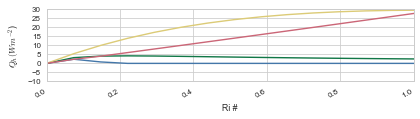

In [5]:
# Figure
fig, axes = plt.subplots(1, 1, figsize=(6, 1.5))

# Plotting parameters
Qmax = 30
Qmin = -10
RiMax = 1
RiMin = 0

# Bulk Richardson number
RiBulk,_,_ = turbpy.bulkRichardson(airTemp,sfcTemp,windspd,mHeight)
ax = axes

for stab, stabTitle in zip(ixStability, ixStabilityTitles):
    ax.plot(RiBulk, senHeatGround[stabTitle], color=colr[stabTitle], label=stabTitle)
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')

fig.tight_layout()
fig.autofmt_xdate()

In [11]:
ixStabilityCapping = ('standard', 'louisInversePower', 'mahrtExponential', 'moninObukhov')
ixStabilityCappingTitles = ('Anderson', 'Louis', 'Mahrt', 'Monin-Obukhov')

riLen = RiBulk.size
z0 = [0.05, 0.005, 0.0005]
zLen = 3
stabilitySchemes = {
    ixStabilityCappingTitles[0]: np.zeros((riLen, zLen)),
    ixStabilityCappingTitles[1]: np.zeros((riLen, zLen)),
    ixStabilityCappingTitles[2]: np.zeros((riLen, zLen)),
    ixStabilityCappingTitles[3]: np.zeros((riLen, zLen)),
    }
conductanceSensible = {
    ixStabilityCappingTitles[0]: np.zeros((riLen, zLen)),
    ixStabilityCappingTitles[1]: np.zeros((riLen, zLen)),
    ixStabilityCappingTitles[2]: np.zeros((riLen, zLen)),
    ixStabilityCappingTitles[3]: np.zeros((riLen, zLen)),
    }
senHeatGround = {
    ixStabilityCappingTitles[0]: np.zeros((riLen, zLen)),
    ixStabilityCappingTitles[1]: np.zeros((riLen, zLen)),
    ixStabilityCappingTitles[2]: np.zeros((riLen, zLen)),
    ixStabilityCappingTitles[3]: np.zeros((riLen, zLen)),
    }

## Calculate stability
for stab, stabTitle in zip(ixStabilityCapping, ixStabilityCappingTitles):
    for nz, z in enumerate(z0):
        for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):
            # Offline Turbulence Package
            (conductanceSensible[stabTitle][n, nz], _, senHeatGround[stabTitle][n, nz], _, _, stabOutput, _, _) \
                = turbpy.turbFluxes(tair, airPressure, vp, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                                    groundSnowFraction=1,
                                    ixDerivMethod=False,
                                    ixStability=stab,
                                    ixStabParam=mc.stabParams,
                                    z0Ground=z,
                                    windlessExchange=windlessExchange)

            # Unpack stability parameters dictionary
            if not 'moninObukhov' in stab:
                stabilitySchemes[stabTitle][n, nz] = stabOutput['stabilityCorrection']
            else:
                stabilitySchemes[stabTitle][n, nz] = np.nan

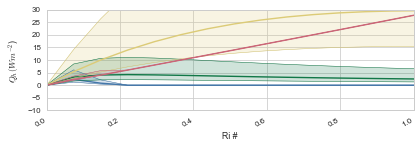

In [22]:
# Figure
fig, axes = plt.subplots(1, 1, figsize=(6, 2))

# Plotting parameters
Qmax = 30
Qmin = -10
RiMax = 1
RiMin = 0

# Bulk Richardson number
RiBulk,_,_ = turbpy.bulkRichardson(airTemp,sfcTemp,windspd,mHeight)
ax = axes

for stab, stabTitle in zip(ixStability, ixStabilityTitles):
    ax.fill_between(RiBulk, senHeatGround[stabTitle].min(axis=1), senHeatGround[stabTitle].max(axis=1),
                   facecolor=colr[stabTitle], alpha=.2)
    ax.plot(RiBulk, senHeatGround[stabTitle].max(axis=1), color=colr[stabTitle], label=stabTitle, linewidth=.5)
    ax.plot(RiBulk, senHeatGround[stabTitle].min(axis=1), color=colr[stabTitle], label=stabTitle, linewidth=.5)
    ax.plot(RiBulk, senHeatGround[stabTitle][:, 1], color=colr[stabTitle], label=stabTitle)
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')

fig.tight_layout()
fig.autofmt_xdate()